In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [10]:
data = pd.read_csv('train.csv')

In [11]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#Разделяем на тренировочные и тестовые данные

data_train, data_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data['SalePrice'], test_size=0.30, random_state=42)

In [ ]:
#Находим категориальные признаки

categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data_train[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[categorials] = data[categorials].fillna('nan')

In [ ]:
#отфильтруем непрерывные признаки
integer = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

In [ ]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([data_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis=1)

##  Бегинг

In [ ]:
from sklearn.ensemble import  BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
bagging = BaggingRegressor(DecisionTreeRegressor(), max_samples=0.5, max_features=0.5)

In [ ]:
bagging.fit(X_train, y_train)


BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=T

In [ ]:
bagging.score(X_train, y_train)

0.9222399687757497

In [ ]:
bagging.score(X_test, y_test)

0.8630730565888741

In [ ]:
# Создаем модель RandomForest
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# проверяем полученные данные на тренировочных данных

clf_rf.score(X_train, y_train)

0.9763593894108274

In [ ]:
# проверяем полученные данные на тестовых данных

clf_rf.score(X_test, y_test)

#Модель получилась не много переобученной

0.8872726574116736

In [ ]:
# Выявляем наиболее важные признаки и выводим на график. Большое значение имеет признак Overall Qual, остальные почти равны нулю

imp = pd.Series(clf_rf.feature_importances_)

In [ ]:
imp.index = pd.Series(X_train.columns)

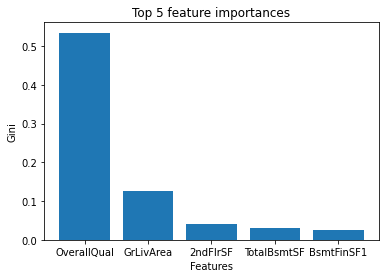

In [ ]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index, imp.sort_values(ascending=False).head())
plt.show()

## Стекинг

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [ ]:
# Создаем стэккинг и обучаем его на наших данных 

Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV())

In [ ]:
Regressor.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('LinearRegression',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('KNeighborsRegressor',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('DecisionTree',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     c...
                                                     min_impurity_decrease=0.0,
                      

In [ ]:
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data 0.9438781984020668
Score on test data 0.8554860675114524
Score on train data with model LinearRegression 0.9221085403562431
Score on test data with model LinearRegression 0.8533836050579261
Score on train data with model KNeighborsRegressor 0.7419951520813983
Score on test data with model KNeighborsRegressor 0.6775304068635524
Score on train data with model DecisionTree 1.0
Score on test data with model DecisionTree 0.7087475395606244


Лучше всех справилась Линейная регрессия.
Деревья решений, как и предполагалось, переобучилась. Алгоритм ближайшего соседа тоже не плохо справилась с задачей. 

In [ ]:
score_train = {}
score_test = {}

for i in Regressor.named_estimators:
    score_train[i] = Regressor.named_estimators_[i].score(X_train, y_train)
    score_test[i] = Regressor.named_estimators_[i].score(X_test, y_test)

score_train['Total']= Regressor.score(X_train, y_train)
score_test['Total']= Regressor.score(X_test, y_test)

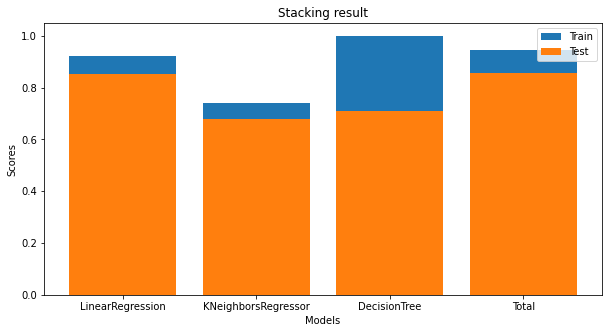

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(len(score_train)), score_train.values(), align="center", label='Train')
plt.xticks(range(len(score_train)), list(score_train.keys()))
plt.bar(range(len(score_test)), score_test.values(), align="center", label='Test')
plt.xticks(range(len(score_test)), list(score_test.keys()))
plt.autoscale
plt.title('Stacking result')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()

## Бустинг

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor()

lgbm.fit(X_train, y_train)

pred = lgbm.predict(X_test)



In [ ]:
from  sklearn.metrics import r2_score

r2_score( pred, y_test)

0.8801863245832537